In [1]:
# initialization
import numpy as np

# importing Qiskit

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
# import basic plot tools
from qiskit.visualization import plot_histogram

In [4]:
def simon_oracle(b):
    """returns a Simon oracle for bitstring b"""
    b = b[::-1] # reverse b for easy iteration
    n = len(b)
    qc = QuantumCircuit(n*2)
    # Do copy; |x>|0> -> |x>|x>
    for q in range(n):
        qc.cx(q, q+n)
    if '1' not in b: 
        return qc  # 1:1 mapping, so just exit
    i = b.find('1') # index of first non-zero bit in b
    # Do |x> -> |s.x> on condition that q_i is 1
    for q in range(n):
        if b[q] == '1':
            qc.cx(i, (q)+n)
    return qc 

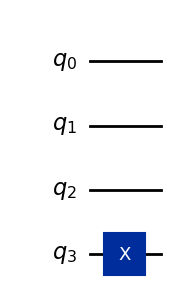

In [11]:
# Constant oracle, n is the number of inputs to the functio
n=3
const_oracle = QuantumCircuit(n+1)

# Randomly choose between 0 and 1 as the oracle output

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)  # if 1 flip the auxilary qubit
const_oracle.draw('mpl')

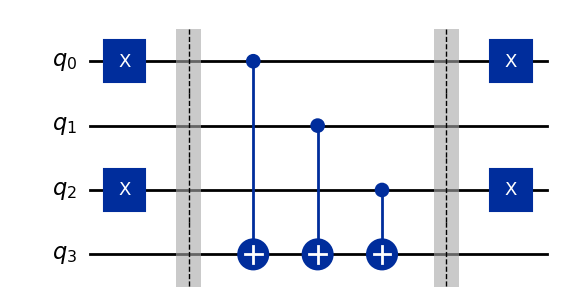

In [12]:
n=3
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw('mpl')

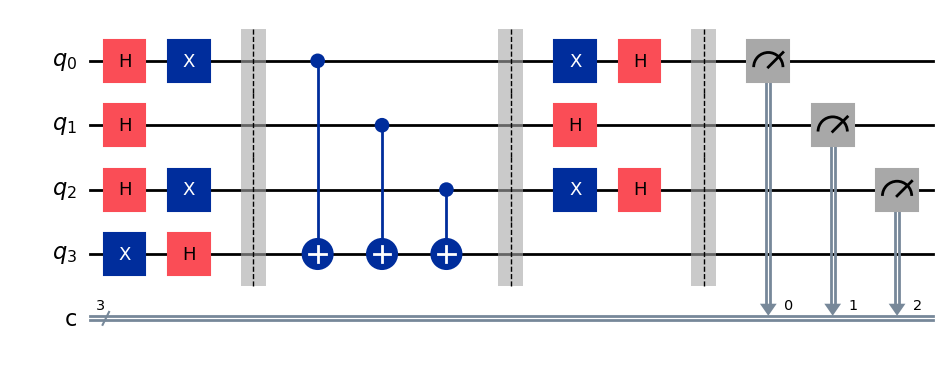

In [13]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
#dj_circuit += balanced_oracle
dj_circuit.compose(balanced_oracle, inplace=True)

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')

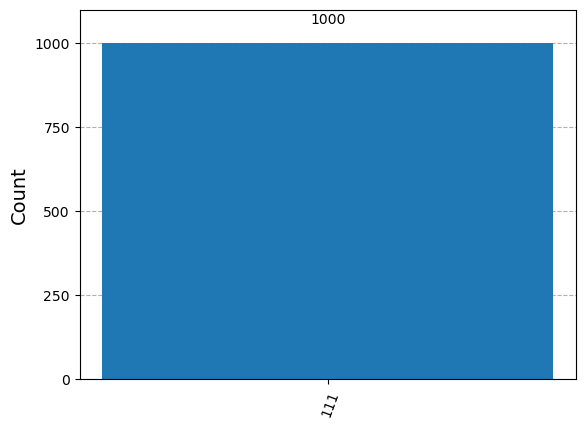

In [15]:
simulator = AerSimulator()
qcc = transpile(dj_circuit, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

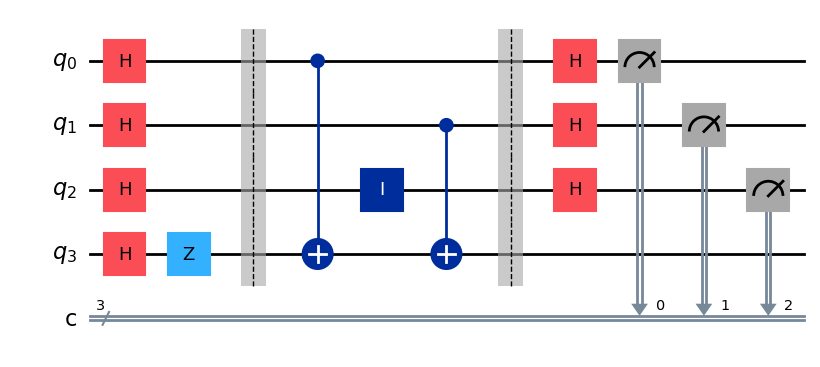

In [17]:
n = 3 # number of qubits used to represent s
s = '011'   # the hidden binary string
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.id(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw('mpl')

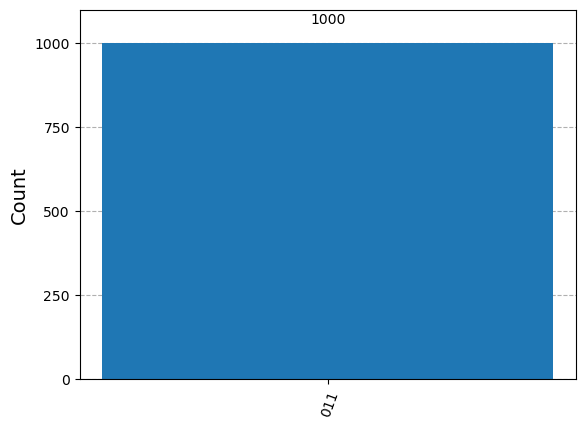

In [19]:
simulator = AerSimulator()
qcc = transpile(bv_circuit, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

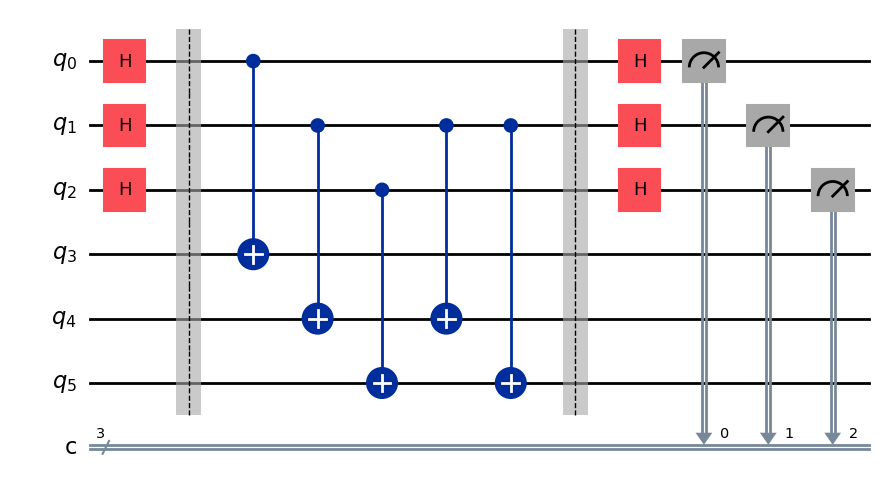

In [20]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

simon_circuit.compose(simon_oracle(b), inplace=True)

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw('mpl')

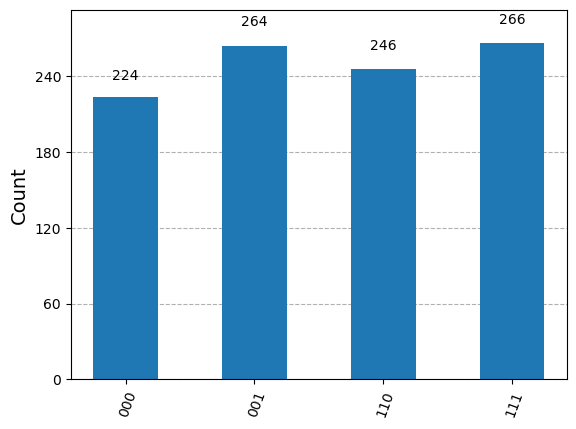

In [22]:
simulator = AerSimulator()
qcc = transpile(simon_circuit, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())